In [1]:
# %% [markdown]
# # Unified LONG + SHORT trade classifier (PnL-aware)
#
# This notebook trains a single deep learning classifier on *both* LONG and SHORT
# trades of the MNQ strategy. The model:
#
# - Input:
#   - Time-series window: (T=160, F=18) features per trade
#   - Snapshot features: 17 features + 1 flag: is_short (0=LONG, 1=SHORT)
# - Output:
#   - p(win) = P(net PnL > 0) for each trade
#
# Training:
# - Data: LONG + SHORT trades from prepared NPZ files (output of data_prep.py)
# - Loss: PnL-aware BCEWithLogitsLoss (heavier weight for large |PnL| trades)
# - Optimizer: AdamW + ReduceLROnPlateau scheduler
# - Early stopping: validation loss (BCE) with patience
#
# Evaluation:
# - Standard classification metrics (accuracy, precision, recall, F1, ROC-AUC)
# - Direction-specific analysis (LONG vs SHORT)
# - Strategy-level PnL:
#     * Baseline (all trades executed)
#     * Filter with probability >= 0.5 (for reference)
#     * Filter with direction-specific, profit-optimized thresholds
#       (tuned on validation set, applied to test set)

# %% 
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

PREPARED_DIR = Path("./prepared")
assert PREPARED_DIR.exists(), "prepared/ directory not found. Run data_prep.py first."


Using device: cuda


In [2]:
# %% [markdown]
# ## 2. Load and combine LONG + SHORT splits
#
# For each split ('train', 'valid', 'test'):
# - Load long_{split}.npz and short_{split}.npz
# - Extend snapshot with an `is_short` flag (0 for LONG, 1 for SHORT)
# - Concatenate into a unified dataset:
#     X_series_combined, X_snapshot_combined, y_usd, y_bin, is_short, meta

# %%
def load_direction_npz(direction: str, split: str):
    """
    direction: 'long' or 'short'
    split: 'train', 'valid', 'test'
    Returns:
        X_series:   (N, T, F)
        X_snapshot:(N, S)
        y_usd:     (N,)
        meta:      dict with sample_id, timestamp, direction, exit_reason
    """
    path = PREPARED_DIR / f"{direction}_{split}.npz"
    with np.load(path, allow_pickle=True) as z:
        X_series   = z["X_series"]
        X_snapshot = z["X_snapshot"]
        y_usd      = z["y"]

        sample_id   = np.array(z["sample_id"]).astype(str)
        timestamp   = np.array(z["timestamp"]).astype(str)
        direction_s = np.array(z["direction"]).astype(str)
        exit_reason = np.array(z["exit_reason"]).astype(str)

        meta = {
            "sample_id":  sample_id,
            "timestamp":  timestamp,
            "direction":  direction_s,
            "exit_reason": exit_reason,
        }

    print(
        f"[{direction.upper()}] {split}: "
        f"X_series={X_series.shape}, X_snapshot={X_snapshot.shape}, y={y_usd.shape}, "
        f"y_mean={y_usd.mean():.4f}, y_std={y_usd.std():.4f}"
    )
    return X_series, X_snapshot, y_usd, meta


def load_combined_split(split: str):
    """
    Load LONG and SHORT NPZs for the given split, extend snapshot with is_short,
    and concatenate. Returns:
        X_series:   (N_total, T, F)
        X_snapshot:(N_total, S+1)  (original snapshot + is_short flag)
        y_usd:     (N_total,)
        y_bin:     (N_total,)  0/1 label: 1 if PnL>0, else 0
        is_short:  (N_total,)  0 for LONG trades, 1 for SHORT trades
        meta:      dict with sample_id, timestamp, direction, exit_reason
    """
    # LONG
    Xs_L, Xp_L, y_L, meta_L = load_direction_npz("long", split)
    N_L = Xs_L.shape[0]
    is_short_L = np.zeros((N_L, 1), dtype=np.float32)

    # SHORT
    Xs_S, Xp_S, y_S, meta_S = load_direction_npz("short", split)
    N_S = Xs_S.shape[0]
    is_short_S = np.ones((N_S, 1), dtype=np.float32)

    # Extend snapshot with is_short flag
    Xp_L_ext = np.concatenate([Xp_L.astype(np.float32), is_short_L], axis=1)
    Xp_S_ext = np.concatenate([Xp_S.astype(np.float32), is_short_S], axis=1)

    # Combine
    X_series   = np.concatenate([Xs_L, Xs_S], axis=0).astype(np.float32)
    X_snapshot = np.concatenate([Xp_L_ext, Xp_S_ext], axis=0).astype(np.float32)
    y_usd      = np.concatenate([y_L, y_S], axis=0).astype(np.float32)
    y_bin      = (y_usd > 0.0).astype(np.float32)
    is_short   = np.concatenate([
        np.zeros(N_L, dtype=np.int64),
        np.ones(N_S,  dtype=np.int64)
    ], axis=0)

    # Meta join
    meta = {
        "sample_id":  np.concatenate([meta_L["sample_id"],  meta_S["sample_id"]]),
        "timestamp":  np.concatenate([meta_L["timestamp"],  meta_S["timestamp"]]),
        "direction":  np.concatenate([meta_L["direction"],  meta_S["direction"]]),
        "exit_reason":np.concatenate([meta_L["exit_reason"],meta_S["exit_reason"]]),
    }

    # Shuffle inside the split (just to avoid "all long then all short") – deterministic
    rng = np.random.default_rng(SEED + hash(split) % 10000)
    idx = rng.permutation(X_series.shape[0])

    X_series   = X_series[idx]
    X_snapshot = X_snapshot[idx]
    y_usd      = y_usd[idx]
    y_bin      = y_bin[idx]
    is_short   = is_short[idx]
    meta = {k: v[idx] for k, v in meta.items()}

    print(
        f"[COMBINED] {split}: X_series={X_series.shape}, "
        f"X_snapshot={X_snapshot.shape}, y_usd_mean={y_usd.mean():.4f}, "
        f"pos_rate={y_bin.mean():.3f}, short_frac={is_short.mean():.3f}"
    )

    return X_series, X_snapshot, y_usd, y_bin, is_short, meta


X_tr_series, X_tr_snap, y_tr_usd, y_tr_bin, is_short_tr, meta_tr = load_combined_split("train")
X_va_series, X_va_snap, y_va_usd, y_va_bin, is_short_va, meta_va = load_combined_split("valid")
X_te_series, X_te_snap, y_te_usd, y_te_bin, is_short_te, meta_te = load_combined_split("test")

T = X_tr_series.shape[1]
F = X_tr_series.shape[2]
S = X_tr_snap.shape[1]   # 17 snapshot + 1 is_short = 18

print(f"\nFinal shapes: T={T}, F={F}, S={S} (snapshot incl. is_short)")


[LONG] train: X_series=(1384, 160, 18), X_snapshot=(1384, 17), y=(1384,), y_mean=1.8388, y_std=134.9398
[SHORT] train: X_series=(1390, 160, 18), X_snapshot=(1390, 17), y=(1390,), y_mean=0.4201, y_std=101.3202
[COMBINED] train: X_series=(2774, 160, 18), X_snapshot=(2774, 18), y_usd_mean=1.1279, pos_rate=0.449, short_frac=0.501
[LONG] valid: X_series=(462, 160, 18), X_snapshot=(462, 17), y=(462,), y_mean=10.3098, y_std=146.8674
[SHORT] valid: X_series=(464, 160, 18), X_snapshot=(464, 17), y=(464,), y_mean=-1.0627, y_std=96.6907
[COMBINED] valid: X_series=(926, 160, 18), X_snapshot=(926, 18), y_usd_mean=4.6113, pos_rate=0.445, short_frac=0.501
[LONG] test: X_series=(462, 160, 18), X_snapshot=(462, 17), y=(462,), y_mean=9.3164, y_std=175.2634
[SHORT] test: X_series=(463, 160, 18), X_snapshot=(463, 17), y=(463,), y_mean=8.3856, y_std=134.1407
[COMBINED] test: X_series=(925, 160, 18), X_snapshot=(925, 18), y_usd_mean=8.8505, pos_rate=0.455, short_frac=0.501

Final shapes: T=160, F=18, S=18 (

In [3]:
# %% [markdown]
# ## 3. Train PnL statistics and Dataset definition

# %%
print("Combined TRAIN PnL stats (USD, LONG+SHORT):")
print(f"mean = {y_tr_usd.mean():.2f}, std = {y_tr_usd.std():.2f}")
for p in [0, 10, 25, 50, 75, 90, 95, 99, 100]:
    print(f"  p{p:2d} = {np.percentile(y_tr_usd, p):8.2f}")

y_tr_std = float(y_tr_usd.std())
if y_tr_std < 1e-8:
    y_tr_std = 1.0
print(f"\nUsing y_tr_std={y_tr_std:.2f} as PnL scale for sample-weighting.")


class TradesClsDataset(Dataset):
    def __init__(self, X_series, X_snapshot, y_usd, y_bin, is_short):
        """
        X_series:   (N, T, F)
        X_snapshot:(N, S) - includes is_short as last column
        y_usd:     (N,)   net PnL in USD
        y_bin:     (N,)   0/1 label: PnL>0
        is_short:  (N,)   0=LONG, 1=SHORT
        """
        self.X_series = X_series.astype(np.float32)
        self.X_snapshot = X_snapshot.astype(np.float32)
        self.y_usd = y_usd.astype(np.float32)
        self.y_bin = y_bin.astype(np.float32)
        self.is_short = is_short.astype(np.int64)

    def __len__(self):
        return self.X_series.shape[0]

    def __getitem__(self, idx):
        ts = self.X_series[idx]           # (T, F)
        ts = np.transpose(ts, (1, 0))     # (F, T) for Conv1d
        snap = self.X_snapshot[idx]       # (S,)
        label = self.y_bin[idx]
        y_usd = self.y_usd[idx]
        is_sh = self.is_short[idx]
        return (
            torch.from_numpy(ts),
            torch.from_numpy(snap),
            torch.tensor(label, dtype=torch.float32),
            torch.tensor(y_usd, dtype=torch.float32),
            torch.tensor(is_sh, dtype=torch.int64),
        )


train_dataset = TradesClsDataset(X_tr_series, X_tr_snap, y_tr_usd, y_tr_bin, is_short_tr)
valid_dataset = TradesClsDataset(X_va_series, X_va_snap, y_va_usd, y_va_bin, is_short_va)
test_dataset  = TradesClsDataset(X_te_series, X_te_snap, y_te_usd, y_te_bin, is_short_te)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("\nDataset sizes:")
print(f"  train: {len(train_dataset)}")
print(f"  valid: {len(valid_dataset)}")
print(f"  test:  {len(test_dataset)}")


Combined TRAIN PnL stats (USD, LONG+SHORT):
mean = 1.13, std = 119.29
  p 0 =  -372.90
  p10 =  -111.67
  p25 =   -66.91
  p50 =     0.00
  p75 =    38.35
  p90 =   134.50
  p95 =   204.41
  p99 =   436.85
  p100 =   799.18

Using y_tr_std=119.29 as PnL scale for sample-weighting.

Dataset sizes:
  train: 2774
  valid: 926
  test:  925


In [4]:
# %% [markdown]
# ## 4. Model architecture: TCN (time series) + MLP (snapshot) + classifier head
#
# Single shared model for both LONG and SHORT trades.
# Direction is encoded via the snapshot feature `is_short`.

# %%
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, dilation=1, dropout=0.1):
        super().__init__()
        padding = (kernel_size - 1) // 2 * dilation

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation,
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation,
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # x: (batch, channels, time)
        residual = x

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out = out + residual
        out = torch.relu(out)
        return out


class TemporalConvNet(nn.Module):
    def __init__(self, in_channels=18, hidden_channels=64, num_layers=3,
                 kernel_size=5, dropout=0.1):
        super().__init__()
        layers = []
        channels = in_channels
        for i in range(num_layers):
            dilation = 2 ** i  # 1, 2, 4
            layers.append(
                TCNBlock(
                    channels,
                    hidden_channels,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout,
                )
            )
            channels = hidden_channels
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch, channels, time)
        out = self.network(x)
        out = out.mean(dim=2)  # global average pooling
        return out


class SnapshotMLP(nn.Module):
    def __init__(self, in_features, hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class TradeClassifierUnified(nn.Module):
    def __init__(self,
                 series_channels,
                 snapshot_features,
                 tcn_hidden=64,
                 tcn_layers=3,
                 mlp_hidden=64,
                 head_hidden=64,
                 dropout=0.1):
        super().__init__()
        self.tcn = TemporalConvNet(
            in_channels=series_channels,
            hidden_channels=tcn_hidden,
            num_layers=tcn_layers,
            kernel_size=5,
            dropout=dropout,
        )
        self.snap_mlp = SnapshotMLP(
            in_features=snapshot_features,
            hidden=mlp_hidden,
            dropout=dropout,
        )
        combined_in = tcn_hidden + mlp_hidden
        self.head = nn.Sequential(
            nn.Linear(combined_in, head_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1),  # single logit
        )

    def forward(self, x_series, x_snapshot):
        # x_series:   (batch, F, T)
        # x_snapshot:(batch, S)
        series_emb = self.tcn(x_series)
        snap_emb   = self.snap_mlp(x_snapshot)
        combined   = torch.cat([series_emb, snap_emb], dim=1)
        logits     = self.head(combined).squeeze(-1)
        return logits


model = TradeClassifierUnified(
    series_channels=F,
    snapshot_features=S,
    tcn_hidden=64,
    tcn_layers=3,
    mlp_hidden=64,
    head_hidden=64,
    dropout=0.1,
).to(DEVICE)

print(model)


TradeClassifierUnified(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TCNBlock(
        (conv1): Conv1d(18, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (relu1): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (relu2): ReLU()
        (dropout2): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(18, 64, kernel_size=(1,), stride=(1,))
      )
      (1): TCNBlock(
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
        (relu1): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
        (relu2): ReLU()
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (2): TCNBlock(
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
        (relu1): ReLU()
        (dropout1): Dropou

In [5]:
# %% [markdown]
# ## 5. Training utilities: PnL-aware BCE
#
# Loss:
# - Base: BCEWithLogitsLoss(reduction='none', pos_weight=...)
# - Sample weight: w_i = 1 + alpha * min(|PnL_i| / y_tr_std, cap)
#   -> high-absolute-PnL trades matter more for training.

# %%
def compute_batch_stats(logits, labels):
    """
    logits: (B,) raw outputs
    labels: (B,) float 0/1
    Returns:
      probs, preds, accuracy, TP, FP, TN, FN
    """
    with torch.no_grad():
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()

        correct = (preds == labels).float().sum().item()
        total = labels.numel()
        acc = correct / total if total > 0 else 0.0

        tp = ((preds == 1) & (labels == 1)).sum().item()
        fp = ((preds == 1) & (labels == 0)).sum().item()
        tn = ((preds == 0) & (labels == 0)).sum().item()
        fn = ((preds == 0) & (labels == 1)).sum().item()

    return probs, preds, acc, tp, fp, tn, fn


def run_epoch_pnl_weighted(
    model,
    loader,
    optimizer=None,
    pos_weight=1.0,
    pnl_scale=100.0,
    alpha=1.0,
    cap=3.0,
):
    """
    If optimizer is not None -> training mode, else eval mode.
    Loss:
      - BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight)
      - sample_weight_i = 1 + alpha * min(|PnL_i|/pnl_scale, cap)
      - final loss = mean(sample_weight * bce_loss)
    Returns:
      avg_loss, avg_acc, precision, recall, f1
    """
    is_train = optimizer is not None
    if is_train:
        model.train()
    else:
        model.eval()

    pos_weight_t = torch.tensor([pos_weight], device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(
        reduction="none",
        pos_weight=pos_weight_t,
    )

    total_loss = 0.0
    total_samples = 0
    total_correct = 0.0
    total_tp = 0.0
    total_fp = 0.0
    total_tn = 0.0
    total_fn = 0.0

    with torch.set_grad_enabled(is_train):
        for x_series, x_snap, labels, y_usd, is_short in loader:
            x_series = x_series.to(DEVICE)
            x_snap   = x_snap.to(DEVICE)
            labels   = labels.to(DEVICE)
            y_usd    = y_usd.to(DEVICE)

            if is_train:
                optimizer.zero_grad()

            logits = model(x_series, x_snap)  # (B,)
            bce_losses = criterion(logits, labels)  # (B,)

            # PnL-based sample weights
            with torch.no_grad():
                w_mag = 1.0 + alpha * torch.clamp(
                    torch.abs(y_usd) / pnl_scale,
                    max=cap,
                )
            losses = bce_losses * w_mag
            loss = losses.mean()

            if is_train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()

            probs, preds, acc, tp, fp, tn, fn = compute_batch_stats(logits, labels)

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            total_correct += acc * batch_size
            total_tp += tp
            total_fp += fp
            total_tn += tn
            total_fn += fn

    avg_loss = total_loss / total_samples
    avg_acc  = total_correct / total_samples

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall    = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0.0

    return avg_loss, avg_acc, precision, recall, f1


In [6]:
# %% [markdown]
# ## 6. Training loop with AdamW, ReduceLROnPlateau, early stopping

# %%
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Class imbalance weight (positive class)
pos_frac = y_tr_bin.mean()
neg_frac = 1.0 - pos_frac
pos_weight = float(neg_frac / max(pos_frac, 1e-6))

print(f"Train positive fraction={pos_frac:.3f}, pos_weight={pos_weight:.3f}")

LR = 1e-5
EPOCHS = 12000
PATIENCE_ES = 30     # early stopping patience (epochs)
LR_PATIENCE = 10      # scheduler patience
LR_FACTOR = 0.5      # LR reduction factor
MIN_DELTA_ES = 1e-6     # minimum improvement in val_loss
MIN_DELTA_LR = 1e-6

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    threshold=MIN_DELTA_LR,
    verbose=True,
)

history = {
    "train_loss": [],
    "train_acc": [],
    "train_prec": [],
    "train_rec": [],
    "train_f1": [],
    "val_loss": [],
    "val_acc": [],
    "val_prec": [],
    "val_rec": [],
    "val_f1": [],
    "lr": [],
}

best_val_loss = float("inf")
best_state_dict = None
epochs_no_improve = 0

best_epoch = None
best_train_metrics = None
best_val_metrics = None

def get_current_lr(optimizer):
    for pg in optimizer.param_groups:
        return pg["lr"]
    return None

for epoch in range(1, EPOCHS + 1):
    current_lr = get_current_lr(optimizer)

    # Train
    train_loss, train_acc, train_prec, train_rec, train_f1 = run_epoch_pnl_weighted(
        model,
        train_loader,
        optimizer=optimizer,
        pos_weight=pos_weight,
        pnl_scale=y_tr_std,
        alpha=1.0,
        cap=3.0,
    )

    # Validation
    val_loss, val_acc, val_prec, val_rec, val_f1 = run_epoch_pnl_weighted(
        model,
        valid_loader,
        optimizer=None,
        pos_weight=pos_weight,
        pnl_scale=y_tr_std,
        alpha=1.0,
        cap=3.0,
    )

    # Scheduler step on val_loss
    scheduler.step(val_loss)

    # Log
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_prec"].append(train_prec)
    history["train_rec"].append(train_rec)
    history["train_f1"].append(train_f1)

    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_prec"].append(val_prec)
    history["val_rec"].append(val_rec)
    history["val_f1"].append(val_f1)

    history["lr"].append(current_lr)

    print(
        f"Epoch {epoch:03d} | lr={current_lr:.5f} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, train_f1={train_f1:.3f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}, val_f1={val_f1:.3f}"
    )

    # Early stopping on val_loss
    if val_loss < best_val_loss - MIN_DELTA_ES:
        best_val_loss = val_loss
        best_state_dict = model.state_dict()
        epochs_no_improve = 0

        best_epoch = epoch
        best_train_metrics = (train_loss, train_acc, train_prec, train_rec, train_f1)
        best_val_metrics = (val_loss, val_acc, val_prec, val_rec, val_f1)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE_ES:
            print("Early stopping triggered (no validation loss improvement).")
            break

# Load best weights
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

print("\nBest epoch:", best_epoch)
if best_train_metrics is not None and best_val_metrics is not None:
    trL, trA, trP, trR, trF = best_train_metrics
    vaL, vaA, vaP, vaR, vaF = best_val_metrics
    print(
        f"  Train: loss={trL:.4f}, acc={trA:.3f}, prec={trP:.3f}, rec={trR:.3f}, f1={trF:.3f}"
    )
    print(
        f"  Valid: loss={vaL:.4f}, acc={vaA:.3f}, prec={vaP:.3f}, rec={vaR:.3f}, f1={vaF:.3f}"
    )

MODEL_DIR = Path("./models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODEL_DIR / "unified_long_short_classifier.pt"
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "config": {
            "T": T,
            "F": F,
            "S": S,
            "LR": LR,
            "BATCH_SIZE": BATCH_SIZE,
            "EPOCHS": EPOCHS,
            "pos_weight": pos_weight,
            "y_tr_std": y_tr_std,
        },
        "history": history,
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
    },
    model_path,
)

print("Saved best unified classifier model to:", model_path)


Train positive fraction=0.449, pos_weight=1.226


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | lr=0.00001 | train_loss=1.2522, train_acc=0.450, train_f1=0.620 | val_loss=1.2434, val_acc=0.445, val_f1=0.616
Epoch 002 | lr=0.00001 | train_loss=1.2516, train_acc=0.450, train_f1=0.620 | val_loss=1.2432, val_acc=0.445, val_f1=0.616
Epoch 003 | lr=0.00001 | train_loss=1.2502, train_acc=0.449, train_f1=0.620 | val_loss=1.2430, val_acc=0.445, val_f1=0.616
Epoch 004 | lr=0.00001 | train_loss=1.2500, train_acc=0.450, train_f1=0.620 | val_loss=1.2430, val_acc=0.445, val_f1=0.616
Epoch 005 | lr=0.00001 | train_loss=1.2495, train_acc=0.452, train_f1=0.620 | val_loss=1.2429, val_acc=0.445, val_f1=0.616
Epoch 006 | lr=0.00001 | train_loss=1.2501, train_acc=0.456, train_f1=0.622 | val_loss=1.2429, val_acc=0.445, val_f1=0.616
Epoch 007 | lr=0.00001 | train_loss=1.2497, train_acc=0.451, train_f1=0.616 | val_loss=1.2429, val_acc=0.445, val_f1=0.616
Epoch 008 | lr=0.00001 | train_loss=1.2489, train_acc=0.456, train_f1=0.617 | val_loss=1.2429, val_acc=0.446, val_f1=0.615
Epoch 009 | lr=0

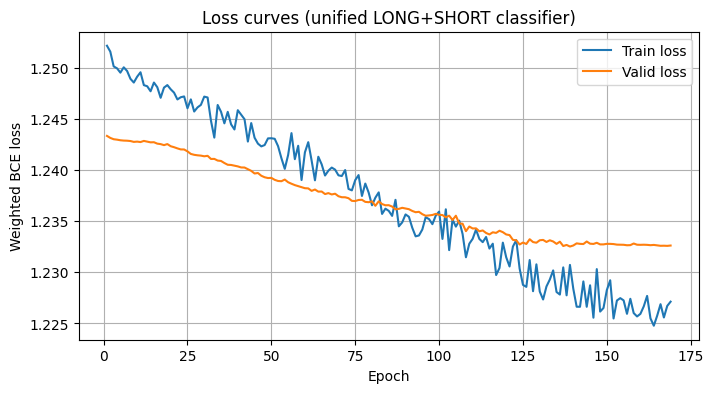

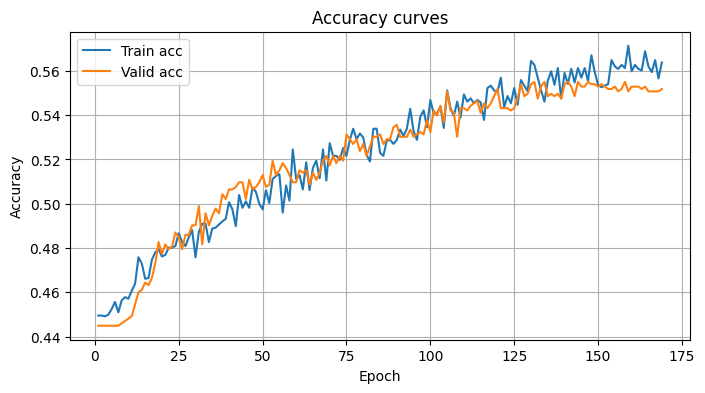

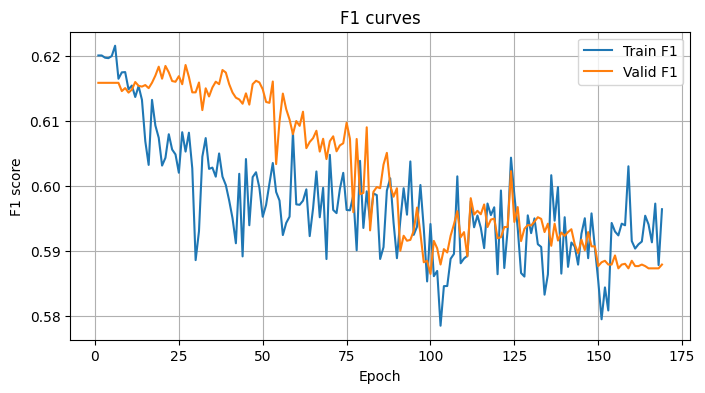

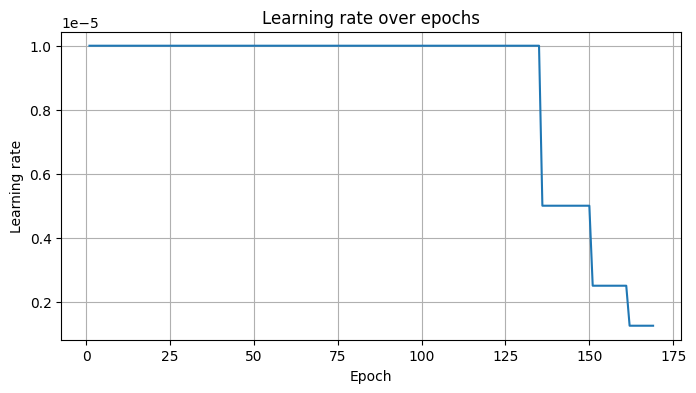

In [7]:
# %% [markdown]
# ## 7. Learning curves

# %%
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.xlabel("Epoch")
plt.ylabel("Weighted BCE loss")
plt.title("Loss curves (unified LONG+SHORT classifier)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"], label="Valid acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, history["train_f1"], label="Train F1")
plt.plot(epochs, history["val_f1"], label="Valid F1")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("F1 curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Learning rate over epochs")
plt.grid(True)
plt.show()


In [1]:
# %% [markdown]
# ## 8. Collect outputs on TEST set (for metrics and PnL analysis)

# %%
def collect_outputs(model, loader):
    """
    Run model on a loader and collect:
      labels (0/1), probs, logits, y_usd, is_short
    """
    model.eval()
    all_labels = []
    all_probs = []
    all_logits = []
    all_yusd = []
    all_is_short = []

    with torch.no_grad():
        for x_series, x_snap, labels, y_usd, is_short in loader:
            x_series = x_series.to(DEVICE)
            x_snap   = x_snap.to(DEVICE)
            labels   = labels.to(DEVICE)
            y_usd    = y_usd.to(DEVICE)
            is_short = is_short.to(DEVICE)

            logits = model(x_series, x_snap)
            probs  = torch.sigmoid(logits)

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_logits.append(logits.cpu().numpy())
            all_yusd.append(y_usd.cpu().numpy())
            all_is_short.append(is_short.cpu().numpy())

    labels_arr   = np.concatenate(all_labels)
    probs_arr    = np.concatenate(all_probs)
    logits_arr   = np.concatenate(all_logits)
    yusd_arr     = np.concatenate(all_yusd)
    is_short_arr = np.concatenate(all_is_short)

    return labels_arr, probs_arr, logits_arr, yusd_arr, is_short_arr


labels_te, probs_te, logits_te, yusd_te, is_short_te = collect_outputs(model, test_loader)

preds_te = (probs_te >= 0.5).astype(np.float32)

acc = (preds_te == labels_te).mean()
cm  = confusion_matrix(labels_te, preds_te)
report = classification_report(labels_te, preds_te, digits=3, target_names=["loss/zero", "win"])

try:
    roc_auc = roc_auc_score(labels_te, probs_te)
except ValueError:
    roc_auc = float("nan")

print("=== TEST metrics (unified, threshold=0.5) ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC:  {roc_auc:.3f}")
print("\nClassification report:")
print(report)

print("Confusion matrix:")
print(cm)


NameError: name 'model' is not defined

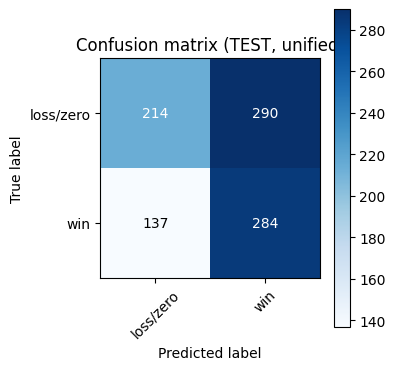

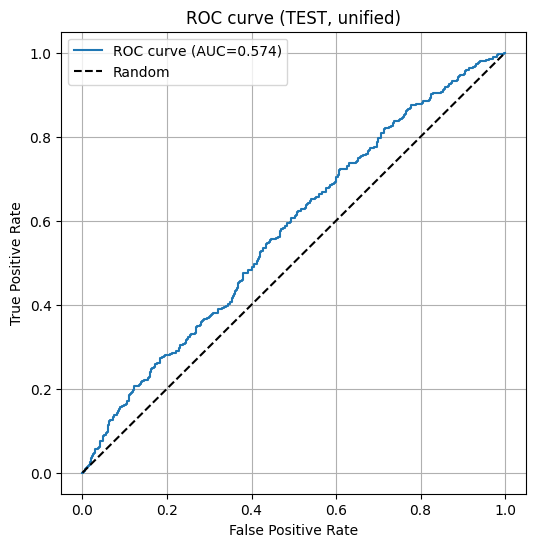

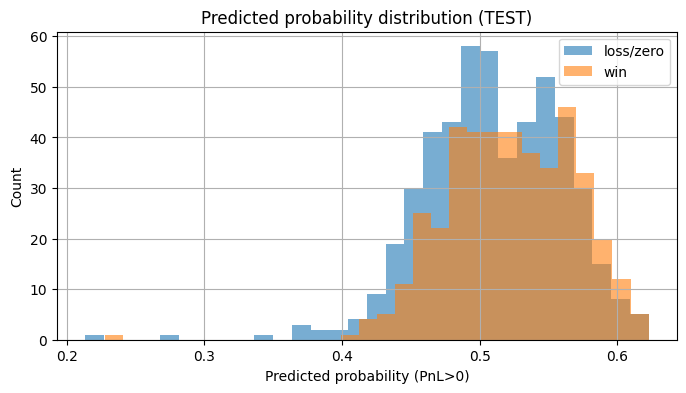

In [9]:
# %% [markdown]
# ## 9. Confusion matrix heatmap, ROC, probability histograms

# %%
# Confusion matrix heatmap
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion matrix (TEST, unified)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["loss/zero", "win"], rotation=45)
plt.yticks(tick_marks, ["loss/zero", "win"])

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(labels_te, probs_te)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (TEST, unified)")
plt.legend()
plt.grid(True)
plt.show()

# Probability histograms
plt.figure(figsize=(8, 4))
plt.hist(probs_te[labels_te == 0], bins=30, alpha=0.6, label="loss/zero")
plt.hist(probs_te[labels_te == 1], bins=30, alpha=0.6, label="win")
plt.xlabel("Predicted probability (PnL>0)")
plt.ylabel("Count")
plt.title("Predicted probability distribution (TEST)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# %% [markdown]
# ## 10. Profit-based threshold tuning (VALIDATION, per direction)
#
# For each direction (LONG, SHORT):
# - Scan thresholds in [0, 1].
# - For each threshold thr:
#     trades_taken = PnL where p >= thr for that direction
# - Pick thr that maximizes total PnL on validation.
#
# These thresholds are then applied to the TEST set.

# %%
# Collect validation outputs (unified model)
labels_va_out, probs_va_out, logits_va_out, yusd_va_out, is_short_va_out = collect_outputs(
    model, valid_loader
)

def find_best_threshold_for_direction(probs, yusd, mask_dir, n_steps=201):
    """
    probs: (N,) predicted probabilities
    yusd: (N,) true net PnL in USD
    mask_dir: boolean mask for the direction (e.g. LONG or SHORT)
    n_steps: number of thresholds between 0 and 1 to scan

    Returns: best_thr, best_pnl, trades_taken_at_best
    """
    probs_d = probs[mask_dir]
    yusd_d  = yusd[mask_dir]

    if len(yusd_d) == 0:
        return 0.5, 0.0, 0

    best_thr = 0.5
    best_pnl = -1e18
    best_trades = 0

    thresholds = np.linspace(0.0, 1.0, n_steps)
    for thr in thresholds:
        take_mask = (probs_d >= thr)
        pnl_taken = yusd_d[take_mask].sum()
        if pnl_taken > best_pnl:
            best_pnl = pnl_taken
            best_thr = thr
            best_trades = int(take_mask.sum())

    return best_thr, float(best_pnl), best_trades


mask_long_va  = (is_short_va_out == 0)
mask_short_va = (is_short_va_out == 1)

baseline_val_pnl_long  = yusd_va_out[mask_long_va].sum()
baseline_val_pnl_short = yusd_va_out[mask_short_va].sum()

thr_long,  best_val_pnl_long,  best_val_trades_long  = find_best_threshold_for_direction(
    probs_va_out, yusd_va_out, mask_long_va, n_steps=201
)
thr_short, best_val_pnl_short, best_val_trades_short = find_best_threshold_for_direction(
    probs_va_out, yusd_va_out, mask_short_va, n_steps=201
)

print("=== Validation PnL and best thresholds ===")
print("LONG:")
print(f"  Baseline PnL (all trades): {baseline_val_pnl_long:.2f} USD")
print(f"  Best thr: {thr_long:.3f}, PnL: {best_val_pnl_long:.2f} USD, "
      f"trades taken: {best_val_trades_long}/{mask_long_va.sum()}")

print("\nSHORT:")
print(f"  Baseline PnL (all trades): {baseline_val_pnl_short:.2f} USD")
print(f"  Best thr: {thr_short:.3f}, PnL: {best_val_pnl_short:.2f} USD, "
      f"trades taken: {best_val_trades_short}/{mask_short_va.sum()}")


=== Validation PnL and best thresholds ===
LONG:
  Baseline PnL (all trades): 4763.15 USD
  Best thr: 0.490, PnL: 5866.24 USD, trades taken: 434/462

SHORT:
  Baseline PnL (all trades): -493.11 USD
  Best thr: 0.520, PnL: 787.85 USD, trades taken: 77/464


In [11]:
# %% [markdown]
# ## 11. Strategy-level PnL on TEST with tuned thresholds
#
# Using thr_long and thr_short found on the validation set, we apply:
# - LONG trades: execute if p >= thr_long
# - SHORT trades: execute if p >= thr_short
#
# and compare vs baseline (all trades executed).

# %%
mask_long_te  = (is_short_te == 0)
mask_short_te = (is_short_te == 1)

baseline_test_pnl_long  = yusd_te[mask_long_te].sum()
baseline_test_pnl_short = yusd_te[mask_short_te].sum()
baseline_test_pnl_total = baseline_test_pnl_long + baseline_test_pnl_short

# Apply thresholds per direction
take_long  = (probs_te >= thr_long)  & mask_long_te
take_short = (probs_te >= thr_short) & mask_short_te
take_any   = take_long | take_short

pnl_long_taken   = yusd_te[take_long].sum()
pnl_short_taken  = yusd_te[take_short].sum()
pnl_total_taken  = pnl_long_taken + pnl_short_taken

pnl_long_skipped  = yusd_te[mask_long_te & (~take_long)].sum()
pnl_short_skipped = yusd_te[mask_short_te & (~take_short)].sum()
pnl_total_skipped = pnl_long_skipped + pnl_short_skipped

n_long_total   = int(mask_long_te.sum())
n_short_total  = int(mask_short_te.sum())
n_long_taken   = int(take_long.sum())
n_short_taken  = int(take_short.sum())
n_long_skipped = n_long_total - n_long_taken
n_short_skipped= n_short_total - n_short_taken

print("=== Strategy-level PnL (TEST, tuned thresholds per direction) ===")

print("\nBaseline (all trades executed):")
print(f"  LONG:  trades={n_long_total},  total PnL={baseline_test_pnl_long:.2f} USD")
print(f"  SHORT: trades={n_short_total}, total PnL={baseline_test_pnl_short:.2f} USD")
print(f"  TOTAL: trades={n_long_total + n_short_total}, "
      f"total PnL={baseline_test_pnl_total:.2f} USD")

print("\nFiltered (p >= thr_long for LONG, p >= thr_short for SHORT):")
print(f"  LONG:  taken={n_long_taken},  skipped={n_long_skipped}, "
      f"Pnl_taken={pnl_long_taken:.2f} USD, Pnl_skipped={pnl_long_skipped:.2f} USD")
print(f"  SHORT: taken={n_short_taken}, skipped={n_short_skipped}, "
      f"Pnl_taken={pnl_short_taken:.2f} USD, Pnl_skipped={pnl_short_skipped:.2f} USD")
print(f"  TOTAL: taken={n_long_taken + n_short_taken}, "
      f"skipped={n_long_skipped + n_short_skipped}, "
      f"Pnl_taken={pnl_total_taken:.2f} USD, Pnl_skipped={pnl_total_skipped:.2f} USD")

profit_gain = pnl_total_taken - baseline_test_pnl_total
print("\nNet effect vs baseline:")
print(f"  Profit gain: {profit_gain:.2f} USD")
if baseline_test_pnl_total != 0:
    print(f"  Relative: {100.0 * profit_gain / abs(baseline_test_pnl_total):.2f}% of |baseline|")


=== Strategy-level PnL (TEST, tuned thresholds per direction) ===

Baseline (all trades executed):
  LONG:  trades=462,  total PnL=4304.18 USD
  SHORT: trades=463, total PnL=3882.53 USD
  TOTAL: trades=925, total PnL=8186.71 USD

Filtered (p >= thr_long for LONG, p >= thr_short for SHORT):
  LONG:  taken=430,  skipped=32, Pnl_taken=-281.59 USD, Pnl_skipped=4585.77 USD
  SHORT: taken=62, skipped=401, Pnl_taken=1666.80 USD, Pnl_skipped=2215.73 USD
  TOTAL: taken=492, skipped=433, Pnl_taken=1385.20 USD, Pnl_skipped=6801.50 USD

Net effect vs baseline:
  Profit gain: -6801.50 USD
  Relative: -83.08% of |baseline|


In [12]:
# %% [markdown]
# ## 12. Comparison with simple 0.5 threshold (optional)

# %%
take_long_05  = (probs_te >= 0.5) & mask_long_te
take_short_05 = (probs_te >= 0.5) & mask_short_te

pnl_long_05  = yusd_te[take_long_05].sum()
pnl_short_05 = yusd_te[take_short_05].sum()
pnl_total_05 = pnl_long_05 + pnl_short_05

print("=== Simple threshold 0.5 vs tuned thresholds (TEST) ===")
print("prob >= 0.5:")
print(f"  LONG PnL:  {pnl_long_05:.2f} USD")
print(f"  SHORT PnL: {pnl_short_05:.2f} USD")
print(f"  TOTAL:     {pnl_total_05:.2f} USD")

print("\nTuned thresholds:")
print(f"  LONG thr={thr_long:.3f},  PnL={pnl_long_taken:.2f} USD")
print(f"  SHORT thr={thr_short:.3f}, PnL={pnl_short_taken:.2f} USD")
print(f"  TOTAL:               {pnl_total_taken:.2f} USD")


=== Simple threshold 0.5 vs tuned thresholds (TEST) ===
prob >= 0.5:
  LONG PnL:  -2221.68 USD
  SHORT PnL: 3461.37 USD
  TOTAL:     1239.69 USD

Tuned thresholds:
  LONG thr=0.490,  PnL=-281.59 USD
  SHORT thr=0.520, PnL=1666.80 USD
  TOTAL:               1385.20 USD
